<a href="https://colab.research.google.com/github/philarnold4242/test_Python/blob/master/Bayesian_DL_ConvNet_Mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 4 - Convolutional Neural Nets<br>
https://www.tensorflow.org/tutorials/deep_cnn

In [0]:
N = 10 # Number of samples for forward pass
Ntrain_steps = 200
bayesian_keep_prob = 0.8

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Uncertainties<br>
Helper functions

In [0]:
# Pseudocount - needs thinking.
pc = 1e-10

def softmax(x):
    """ Multinomial logisitc fuction. """
    mmax = np.amax(x, axis=1).reshape(x.shape[0], 1)
    ex = np.exp(x - mmax)
    ex_sum = ex.sum(axis=1).reshape(ex.shape[0],1)
    return ex / ex_sum
    

def var_ratio(x):
    """ How spread is the distribution around the mode?""" 
    ratios = np.zeros(shape=(x.shape[1]))
    
    # Loop over test examples
    for n in range(x.shape[1]):
        
        # Get predicted class
        samples_n = np.argmax(x[:, n], axis=1)
        
        # Get most abundant class
        count = np.argmax(np.bincount(samples_n))
        
        # Return frequency of class
        ratios[n] = np.sum(samples_n==count) / x.shape[0]

    return ratios


def pred_ent(x):
    """ Average amount of information contained in posterior predictive distribution. """
    
    N = x.shape[1] # Number of test cases
    T = x.shape[0] # Number of samples per test case
    C = 10 # number of classes
    
    entropies = np.zeros(shape=(x.shape[1]))
    
    # Loop over test examples
    for n in range(N):
        
        # Approx posterior predictive distribution
        ppd = np.mean(x[:,n,:] + pc, axis=0)
        
        # Calculate predictive entropy
        entropies[n] = - np.sum(np.multiply(ppd, np.log(ppd)))
    
    return entropies


def mut_inf(x):
    """ MI between prediction y_pred and posterior distribution for the model parameters. """
    
    N = x.shape[1] # Number of test cases
    T = x.shape[0] # Number of samples per test case
    C = 10 # number of classes
        
    mis = np.zeros(shape=(x.shape[1]))
    
    # Loop over test examples
    for n in range(N):
        
        # Approx posterior predictive distribution
        ppd = np.mean(x[:,n,:] + pc, axis=0)
        
        # Calculate predictive entropy
        pe = - np.sum(np.multiply(ppd, np.log(ppd)))
        
        # Calculate conditional entropy        
        p = x[:,n,:] + pc
        logp = np.log(p)
        ce = np.mean(np.multiply(p,logp))
        
        mis[n] = pe - ce

    return mis

## **Let's get started**

### Set up modules

In [4]:
import os
import sys

import numpy as np
np.set_printoptions(precision=5)

import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

import pickle
import urllib
import tarfile

!pip install git+git://github.com/rasbt/mlxtend.git
from mlxtend.data import loadlocal_mnist

import tensorflow as tf
print(tf.__version__)

  Cloning git://github.com/rasbt/mlxtend.git to /tmp/pip-req-build-tmsjutnk
  Running setup.py bdist_wheel for mlxtend ... - \ | done
  Stored in directory: /tmp/pip-ephem-wheel-cache-w9fxbplk/wheels/85/e4/4c/ee71547ac9ea223b07fe8f55b0e5f71536a6a34ae3480205f3
Successfully built mlxtend
  Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0
1.12.0


In [5]:
## Check GPU
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)

with tf.Session() as sess:
    print (sess.run(c))

[[22. 28.]
 [49. 64.]]


### ConvNet - The hard way

In [6]:
## Load MNIST
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

In [0]:
## Helper functions
def weight_variable(shape):
    """ Specifies the weight for either fully-connected or conv layers."""
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)


def bias_variable(shape):
    """ Bias elements. """
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)


def conv2d(x, W):
    """ This specifies a full convolution with an output the same size
        as the input x. 
        [batch, height, width, channels] """
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')


def max_pool_2x2(x):
    """ ksize: A 1-D int Tensor of 4 elements. The size of the window for each 
               dimension of the input tensor.
        strides: A 1-D int Tensor of 4 elements. The stride of the sliding window for 
                 each dimension of the input tensor. """
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

In [0]:
## Architecture parameters
pic_res = 28
n_channel = 1

# Placeholders to feed stuff to network
x = tf.placeholder(tf.float32, shape=[None, pic_res*pic_res])
y_true = tf.placeholder(tf.float32, shape=[None, 10])
keep_prob = tf.placeholder(tf.float32)




In [0]:
def create_convnet(do_bayes = False):
  ## The net
  # Remember, the input image is a 1D tensor of length 784.
  mnist.train.images[1].shape

  # To apply the layer, we first reshape x to a 4d tensor, with the second and 
  # third dimensions corresponding to image width and height, and the final dimension 
  # corresponding to the number of color channels.
  x_image = tf.reshape(x, [-1, pic_res, pic_res, n_channel])

  # First conv layer
  # The convolution will compute 32 features for each 3x3 patch. Its weight tensor will have a 
  # shape of [3, 3, 1, 32]. The first two dimensions are the patch size, the next is the number 
  # of input channels, and the last is the number of output channels. 
  W_conv1 = weight_variable([3, 3, n_channel, 32])
  b_conv1 = bias_variable([32])
  conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
  if do_bayes:
    conv1 = tf.nn.dropout(conv1, keep_prob=keep_prob)
  h_pool1 = max_pool_2x2(conv1)

  # Second conv layer
  W_conv2 = weight_variable([3, 3, 32, 64])
  b_conv2 = bias_variable([64])
  conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
  if do_bayes:
    conv2 = tf.nn.dropout(conv2, keep_prob=keep_prob)
  h_pool2 = max_pool_2x2(conv2)

  # Dense layer 
  pic_res4_sq = int(pic_res/4)*int(pic_res/4)
  W_fc1 = weight_variable([pic_res4_sq * 64, 1024])
  b_fc1 = bias_variable([1024])

  h_pool2_flat = tf.reshape(h_pool2, [-1, pic_res4_sq*64])
  h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
  # Dropout
  h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob=keep_prob)

  # Output
  W_fc2 = weight_variable([1024, 10])
  b_fc2 = bias_variable([10])

  h_fc2 = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
  h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob=keep_prob)
  y_conv = h_fc2_drop
  
  return(y_conv)

## Tranditional ConvNet

In [10]:
# Objective function
y_conv = create_convnet(do_bayes = False)
y_pred = tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=y_conv)
cross_entropy = tf.reduce_mean(y_pred)

# Optimizer
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

# Evaluation
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_true, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [11]:
## Train - MNIST
sess = tf.Session()
sess.run(tf.global_variables_initializer())

for i in range(int(Ntrain_steps)+1):
    batch = mnist.train.next_batch(64)

    # Training
    _, loss = sess.run([train_step, cross_entropy], 
                       feed_dict={x: batch[0], y_true: batch[1], 
                                  keep_prob: float(bayesian_keep_prob)})
    
    # Status report
    if i % 1000 == 0:
        train_acc = sess.run(accuracy, feed_dict={x: batch[0], 
                                                  y_true: batch[1], 
                                                  keep_prob: float(1.0)})
        
        test_acc = sess.run(accuracy, feed_dict={x: mnist.test.images,
                                                  y_true: mnist.test.labels, 
                                                  keep_prob: 1.0})
        info = [str(tx) for tx in [i, loss, train_acc, test_acc] ]
        print('\t'.join(info))
        

0	5.259044	0.140625	0.0807


In [0]:
# Get predictions
y_prob = tf.nn.softmax(y_conv)
pred_trad = sess.run(y_prob, feed_dict={x: mnist.test.images,
                                          y_true: mnist.test.labels, 
                                          keep_prob: 1.0})


labels_trad = np.argmax(pred_trad, axis=1)
probs_trad = np.max(pred_trad, axis=1)

In [13]:
qqq = sess.run(y_prob, feed_dict={x: mnist.test.images,
                                          y_true: mnist.test.labels, 
                                          keep_prob: 1.0})
print(qqq.shape)

(10000, 10)


## Bayesian ConvNet

In [0]:
# Objective function
By_conv = create_convnet(do_bayes = True)
By_pred = tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=By_conv)
Bcross_entropy = tf.reduce_mean(By_pred)

# Optimizer
Btrain_step = tf.train.AdamOptimizer(1e-4).minimize(Bcross_entropy)

# Evaluation
Bcorrect_prediction = tf.equal(tf.argmax(By_conv, 1), tf.argmax(y_true, 1))
Baccuracy = tf.reduce_mean(tf.cast(Bcorrect_prediction, tf.float32))

In [15]:
## Train - MNIST
sess = tf.Session()
sess.run(tf.global_variables_initializer())

for i in range(int(Ntrain_steps)+1):
    batch = mnist.train.next_batch(64)

    # Training
    _, loss = sess.run([Btrain_step, Bcross_entropy], 
                       feed_dict={x: batch[0], y_true: batch[1], 
                                  keep_prob: float(bayesian_keep_prob)})
    
    # Status report
    if i % 1000 == 0:
        train_acc = sess.run(Baccuracy, feed_dict={x: batch[0], 
                                                  y_true: batch[1], 
                                                  keep_prob: float(1.0)})
        
        test_acc = sess.run(Baccuracy, feed_dict={x: mnist.test.images,
                                                  y_true: mnist.test.labels, 
                                                  keep_prob: 1.0})
        info = [str(tx) for tx in [i, loss, train_acc, test_acc] ]
        print('\t'.join(info))

0	9.345818	0.078125	0.0396


**Uncertainties from stochastic forward passes**

In [0]:
## Stochastic forward passes
samples = np.zeros( shape=(N, mnist.test.images.shape[0], 10))

for n in range(N):
    logits = sess.run(By_conv, feed_dict={x: mnist.test.images, 
                                          y_true: mnist.test.labels,
                                         keep_prob: bayesian_keep_prob})
    samples[n] = softmax(logits)

In [0]:
# Variation ratio
vr = var_ratio(samples)

# Predictive entropy
pe = pred_ent(samples)

# Mutual information
mi = mut_inf(samples)

In [0]:
def pred_ent_trad(x):
    """ Average amount of information contained in posterior predictive distribution. """

    N = x.shape[0]
    C = x.shape[1]
    
    entropies = np.zeros(shape=(N))    
    
    for n in range(N):

      # Predictive entropy for traditional approach (just softmax)
      ppd = x[n, :]

      # Calculate predictive entropy
      pe = - np.sum(np.multiply(ppd, np.log(ppd)))
        
      entropies[n] = pe
      
    return(entropies)
  
pe_trad = pred_ent_trad(pred_trad)

In [19]:
import math

y = pred_trad[9679]
print(y)

z = 0.0
for i in range(10):
  
  z = z + y[i] * math.log(y[i])
  
print(z)
print(pe_trad[9679])

[0.11136 0.07052 0.05921 0.04148 0.02234 0.15771 0.50902 0.01388 0.00633
 0.00815]
-1.581358251731326
1.5813583135604858


In [0]:
# Bayesian predictions
samples_avg = np.sum(samples, axis=0) / N
labels_bayes = np.argmax(samples_avg, axis=1)
probs_bayes = np.max(samples_avg, axis=1)

## Comparison: Bayes vs Trad

In [21]:
ref = np.argmax(mnist.test.labels, axis=1)
data = { 'true': ref.tolist(),
         'labels_trad': labels_trad.tolist(),
         'probs_trad': probs_trad.tolist(),
         'labels_bayes': labels_bayes.tolist(),
         'probs_bayes': probs_bayes.tolist(),
         'vr': vr.tolist(),
         'pe': pe.tolist(),
         'mi': mi.tolist(),
         'pe_trad': pe_trad.tolist()}

for k in data.keys():
  print("{} {}".format(k, len(data[k])))

true 10000
labels_trad 10000
probs_trad 10000
labels_bayes 10000
probs_bayes 10000
vr 10000
pe 10000
mi 10000
pe_trad 10000


In [22]:
df = pd.DataFrame(data)

df = df.assign(correct_trad = df.true == df.labels_trad)
df = df.assign(correct_bayes = df.true == df.labels_bayes)

df_both_wrong = df[(df.correct_trad == False) & (df.correct_bayes == False)]
df_both_right = df[(df.correct_trad == True) & (df.correct_bayes == True)]

df.head()

,labels_bayes,labels_trad,mi,pe,pe_trad,probs_bayes,probs_trad,true,vr,correct_trad,correct_bayes
0,7,7,0.296274,0.279767,0.145272,0.947335,0.976233,7,1.0,True,True
1,2,2,0.750120,0.712039,1.323443,0.835519,0.587000,2,0.9,True,True
2,1,1,1.195148,1.120938,0.357326,0.715910,0.938465,1,0.8,True,True
3,0,0,0.764763,0.715813,0.311030,0.838846,0.940883,0,1.0,True,True
4,4,4,1.236261,1.144857,0.892450,0.696492,0.757730,4,0.9,True,True


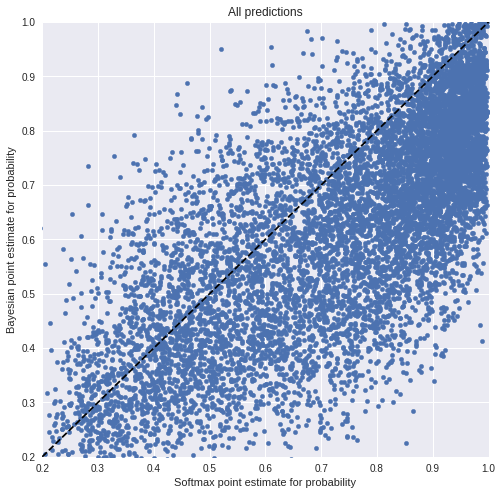

In [23]:
plt.rcParams["figure.figsize"] = (8,8)

def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--', color = "black")

# Best guess
# Traditional approach is much more confidennt than Bayesian approach
ax = df.plot.scatter(x = 'probs_trad', y = 'probs_bayes')
ax.set_xlim(0.2, 1)
ax.set_ylim(0.2, 1)
ax.set_xlabel("Softmax point estimate for probability")
ax.set_ylabel("Bayesian point estimate for probability")
plt.title("All predictions")

abline(1, 0)

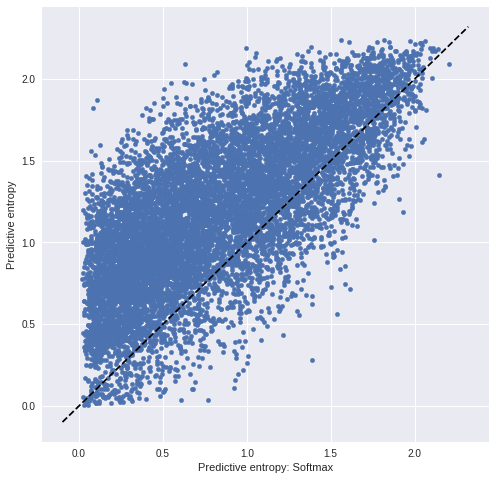

In [24]:
ax = df.plot.scatter(x = 'pe_trad', y = 'pe')
#ax.set_xlim(0.0, 1)
#ax.set_ylim(0., 1)
ax.set_xlabel("Predictive entropy: Softmax")
ax.set_ylabel("Predictive entropy")
abline(1, 0)

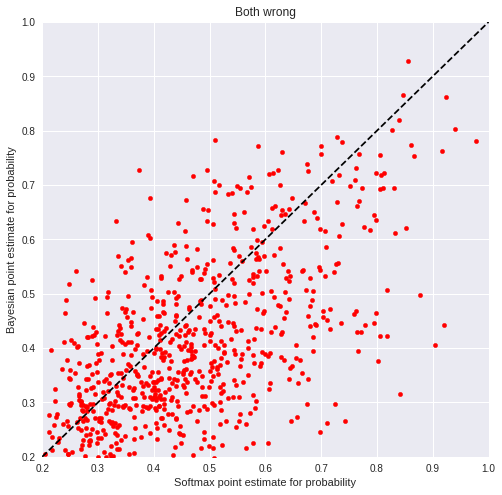

In [25]:
# Things both got wrong
ax = df_both_wrong.plot.scatter(x = 'probs_trad', y = 'probs_bayes', color="red")
ax.set_xlim(0.2, 1)
ax.set_ylim(0.2, 1)
ax.set_xlabel("Softmax point estimate for probability")
ax.set_ylabel("Bayesian point estimate for probability")
plt.title("Both wrong")
abline(1, 0)

### Uncertainty: Predictive Entropy

In [0]:
# Uncertainty measure for correct / incorrectly predicted digits
# https://stackoverflow.com/questions/21887625/python-empirical-distribution-function-ecdf-implementation
df_bayes_correct = df[df.correct_bayes == True]
df_bayes_wrong = df[df.correct_bayes == False]

df_trad_correct = df[df.correct_trad == True]
df_trad_wrong = df[df.correct_trad == False]

In [0]:
# Bayes
uncer_bayes_correct = df_bayes_correct.pe.value_counts()
uncer_bayes_correct = uncer_bayes_correct.sort_index(ascending=False).cumsum()*1./len(uncer_bayes_correct)

uncer_bayes_wrong = df_bayes_wrong.pe.value_counts()
uncer_bayes_wrong = uncer_bayes_wrong.sort_index(ascending=False).cumsum()*1./len(uncer_bayes_wrong)

# Trad
uncer_trad_correct = df_trad_correct.pe_trad.value_counts()
uncer_trad_correct = uncer_trad_correct.sort_index(ascending=False).cumsum()*1./len(uncer_trad_correct)

uncer_trad_wrong = df_trad_wrong.pe_trad.value_counts()
uncer_trad_wrong = uncer_trad_wrong.sort_index(ascending=False).cumsum()*1./len(uncer_trad_wrong)

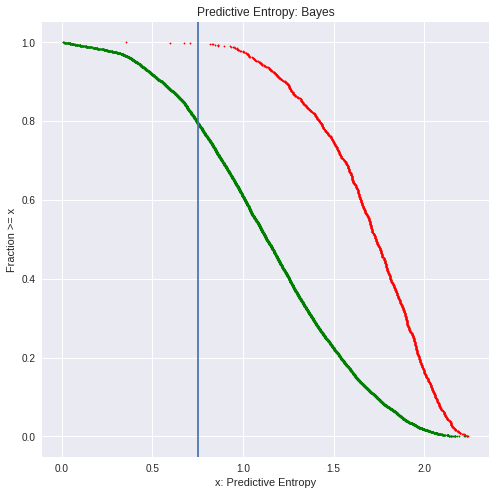

In [28]:
si = 2
plt.scatter(uncer_bayes_correct.index, uncer_bayes_correct, color="green", s=si)
plt.scatter(uncer_bayes_wrong.index, uncer_bayes_wrong, color="red", s=si)
plt.title("Predictive Entropy: Bayes")
plt.xlabel("x: Predictive Entropy")
plt.ylabel("Fraction >= x")
plt.axvline(0.75)

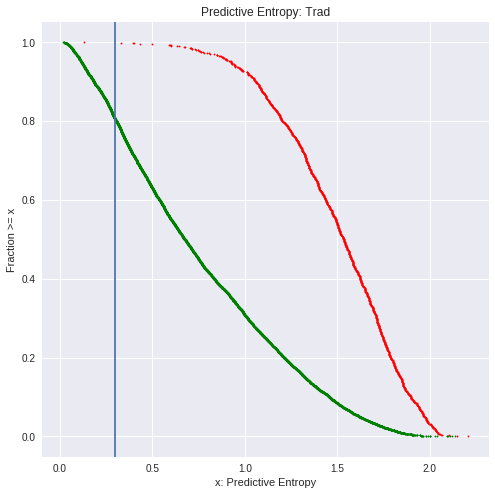

In [29]:
plt.scatter(uncer_trad_correct.index, uncer_trad_correct, color="green", s=si)
plt.scatter(uncer_trad_wrong.index, uncer_trad_wrong, color="red", s=si)
plt.title("Predictive Entropy: Trad")
plt.xlabel("x: Predictive Entropy")
plt.ylabel("Fraction >= x")
plt.axvline(0.3)

Text(0,0.5,'Fraction >= x')

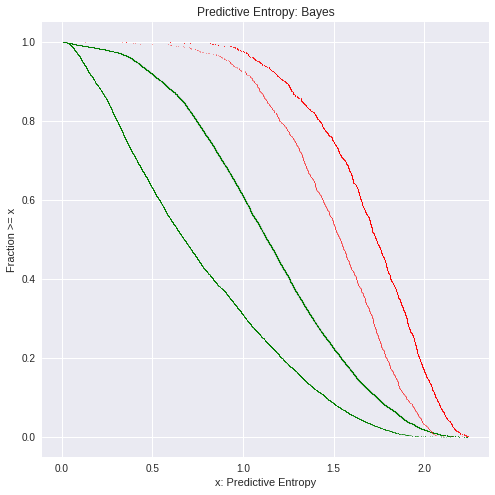

In [30]:
plt.scatter(uncer_bayes_correct.index, uncer_bayes_correct, color="green", s=0.5)
plt.scatter(uncer_bayes_wrong.index, uncer_bayes_wrong, color="red", s=0.5)

plt.scatter(uncer_trad_correct.index, uncer_trad_correct, color="green", s =0.1)
plt.scatter(uncer_trad_wrong.index, uncer_trad_wrong, color="red", s =0.1)

plt.title("Predictive Entropy: Bayes")
plt.xlabel("x: Predictive Entropy")
plt.ylabel("Fraction >= x")

### Uncertainity Mutual information

In [0]:
# Bayes
uncer_bayes_correct = df_bayes_correct.mi.value_counts()
uncer_bayes_correct = uncer_bayes_correct.sort_index(ascending=False).cumsum()*1./len(uncer_bayes_correct)

uncer_bayes_wrong = df_bayes_wrong.mi.value_counts()
uncer_bayes_wrong = uncer_bayes_wrong.sort_index(ascending=False).cumsum()*1./len(uncer_bayes_wrong)

# Trad
uncer_trad_correct = df_trad_correct.pe_trad.value_counts()
uncer_trad_correct = uncer_trad_correct.sort_index(ascending=False).cumsum()*1./len(uncer_trad_correct)

uncer_trad_wrong = df_trad_wrong.pe_trad.value_counts()
uncer_trad_wrong = uncer_trad_wrong.sort_index(ascending=False).cumsum()*1./len(uncer_trad_wrong)

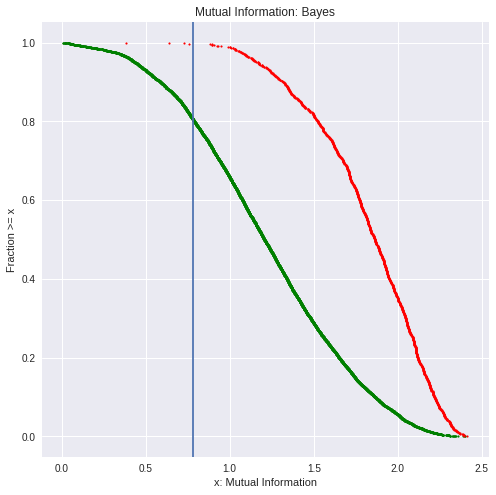

In [32]:
plt.rcParams["figure.figsize"] = (8,8)
si = 3
plt.scatter(uncer_bayes_correct.index, uncer_bayes_correct, color="green", s=si)
plt.scatter(uncer_bayes_wrong.index, uncer_bayes_wrong, color="red", s=si)
plt.title("Mutual Information: Bayes")
plt.xlabel("x: Mutual Information")
plt.ylabel("Fraction >= x")
plt.axvline(0.78)

### Examples

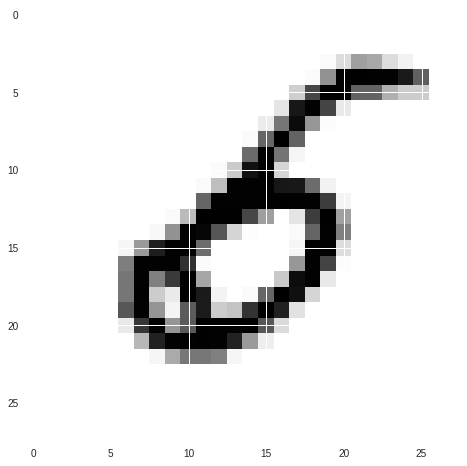

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


,labels_bayes,labels_trad,mi,pe,pe_trad,probs_bayes,probs_trad,true,vr,correct_trad,correct_bayes
9905,9,9,1.748983,1.637431,1.419473,0.348183,0.485640,3,0.5,False,False
9910,5,5,1.441219,1.349348,1.640038,0.434211,0.404400,8,0.5,False,False
9925,8,5,2.281933,2.124164,1.860332,0.200036,0.323251,3,0.3,False,False
9941,6,6,2.032843,1.896395,1.193054,0.296914,0.673690,5,0.4,False,False
9944,8,9,1.751152,1.635159,1.446617,0.350523,0.369954,3,0.4,False,False
9954,0,0,1.872568,1.759105,1.777050,0.341566,0.407090,2,0.4,False,False
9970,3,6,2.155106,1.992544,1.745811,0.292720,0.278178,5,0.6,False,False
9975,2,2,1.865904,1.730275,1.749618,0.492949,0.439259,3,0.9,False,False
9982,6,6,1.231259,1.141578,0.946389,0.708936,0.761365,5,1.0,False,False
9986,8,5,1.726596,1.601930,1.727803,0.372617,0.295830,3,0.5,False,False


In [33]:
k = 9729
# 9729	6	6	mi=0.82	pe=0.79	pe_trad=0.003	prob_b=0.83	prob_t=0.99	ref=5	vr=0.82

plt.imshow(mnist.test.images[k].reshape(28,28))
plt.show()
print(mnist.test.labels[k])
df_both_wrong.tail(n=10)

## EMnist
We know that in this case, the data set is out of distribution. Usually, we don't have this information.

In [34]:
# Download data set from here: https://www.nist.gov/itl/iad/image-group/emnist-dataset
# Upload to gDrive
# Copy from gDrive
!cp '/content/drive/My Drive/Colab Notebooks/emnist.zip' .

!rm -fr gzip

# Unzip
!unzip emnist.zip

Archive:  emnist.zip
  inflating: gzip/emnist-balanced-mapping.txt  
  inflating: gzip/emnist-balanced-test-images-idx3-ubyte.gz  
 extracting: gzip/emnist-balanced-test-labels-idx1-ubyte.gz  
  inflating: gzip/emnist-balanced-train-images-idx3-ubyte.gz  
  inflating: gzip/emnist-balanced-train-labels-idx1-ubyte.gz  
  inflating: gzip/emnist-byclass-mapping.txt  
  inflating: gzip/emnist-byclass-test-images-idx3-ubyte.gz  
  inflating: gzip/emnist-byclass-test-labels-idx1-ubyte.gz  
  inflating: gzip/emnist-byclass-train-images-idx3-ubyte.gz  
  inflating: gzip/emnist-byclass-train-labels-idx1-ubyte.gz  
  inflating: gzip/emnist-bymerge-mapping.txt  
  inflating: gzip/emnist-bymerge-test-images-idx3-ubyte.gz  
  inflating: gzip/emnist-bymerge-test-labels-idx1-ubyte.gz  
  inflating: gzip/emnist-bymerge-train-images-idx3-ubyte.gz  
  inflating: gzip/emnist-bymerge-train-labels-idx1-ubyte.gz  
  inflating: gzip/emnist-digits-mapping.txt  
  inflating: gzip/emnist-digits-test-images-idx3-

In [0]:
import gzip

def _read32(bytestream):
    dt = np.dtype(np.uint32).newbyteorder('>')
    return np.frombuffer(bytestream.read(4), dtype=dt)[0]


def extract_images(filename):
    with gzip.open(filename) as bytestream:
        magic = _read32(bytestream)
        if magic != 2051:
            raise ValueError(
                'Invalid magic number %d in MNIST image file: %s' %
                (magic, filename))
        num_images = _read32(bytestream)
        rows = _read32(bytestream)
        cols = _read32(bytestream)
        buf = bytestream.read(rows * cols * num_images)
        data = np.frombuffer(buf, dtype=np.uint8)
        data = data.reshape(num_images, rows, cols, 1)
        return data


def extract_labels(filename):
    with gzip.open(filename) as bytestream:
        magic = _read32(bytestream)
        if magic != 2049:
            raise ValueError(
              'Invalid magic number %d in MNIST label file: %s' %
              (magic, filename))
        num_items = _read32(bytestream)
        buf = bytestream.read(num_items)
        labels = np.frombuffer(buf, dtype=np.uint8)
        return labels


def read_emnist(emnist_dir):

    TRAIN_IMAGES = emnist_dir+'/emnist-balanced-train-images-idx3-ubyte.gz'
    TRAIN_LABELS = emnist_dir+'/emnist-balanced-train-labels-idx1-ubyte.gz'
    TEST_IMAGES = emnist_dir+'/emnist-balanced-test-images-idx3-ubyte.gz'
    TEST_LABELS = emnist_dir+'/emnist-balanced-test-labels-idx1-ubyte.gz'
    MAPPING = emnist_dir+'/emnist-balanced-mapping.txt'

    train_images = extract_images(TRAIN_IMAGES)
    train_labels = extract_labels(TRAIN_LABELS)
    test_images = extract_images(TEST_IMAGES)
    test_labels = extract_labels(TEST_LABELS)

    with open(MAPPING, "r") as f:
        mapping = f.readlines()
        mapping = {str(x.split()[0]): str(x.split()[1]) for x in mapping}

    # Convert to float32
    train_images = train_images.astype('float32')
    test_images = test_images.astype('float32')

    # Normalize
    train_images /= 255
    test_images /= 255

    # Output format: (28, 28, 1)
    return ((train_images, train_labels), (test_images, test_labels), mapping)

In [36]:
emnist = read_emnist('gzip')

X = np.float32(emnist[1][0].reshape(18800, 784))
y = np.float32(emnist[1][1])
X.shape

(18800, 784)

In [0]:
# Select characters A and Y that are clearly out of distribution
# http://isn.ucsd.edu/courses/bggn260/2017/reports/2017_Group2.pdf

# 1
itemindex1 = np.where(y==1)
X1 = X[itemindex1]

# A
itemindexA = np.where(y==10)
XA = X[itemindexA]

# W
itemindexW = np.where(y==32)
XW = X[itemindexW]

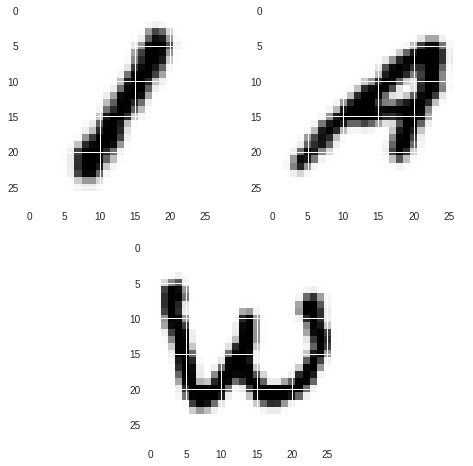

In [38]:
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec

k = 0

# Create 2x2 sub plots
gs = gridspec.GridSpec(2, 2)

pl.figure()
ax = pl.subplot(gs[0, 0]) # row 0, col 0
im = X1[k].reshape((28,28))
pl.plt.imshow(im.T)

ax = pl.subplot(gs[0, 1]) # row 0, col 1
im = XA[k].reshape((28,28))
pl.plt.imshow(im.T)


ax = pl.subplot(gs[1, :]) # row 1, span all columns
im = XW[k].reshape((28,28))
pl.plt.imshow(im.T)

In [0]:
# Predict A, Z, 1

## Trad
def get_probs_trad(input):
  y_prob = tf.nn.softmax(y_conv)
  
  pred_trad = sess.run(y_prob, feed_dict={x: input,                                          
                                         keep_prob: float(1.0)})
  
  labels_trad = np.argmax(pred_trad, axis=1)
  probs_trad = np.max(pred_trad, axis=1)

  Eprobs_trad = probs_trad

  return(Eprobs_trad)


Eprobs_trad1 = get_probs_trad(X1)  
Eprobs_tradA = get_probs_trad(XA)  
Eprobs_tradW = get_probs_trad(XW)  

In [0]:
def get_probs_bayes(input):
    Esamples = np.zeros( shape=(N, input.shape[0], 10))

    for n in range(N):
        logits = sess.run(By_conv, feed_dict={x: input,                                               
                                              keep_prob: bayesian_keep_prob})
        Esamples[n] = softmax(logits)

    Esamples_avg = np.sum(Esamples, axis=0) / N
    Elabels_bayes = np.argmax(Esamples_avg, axis=1)
    Eprobs_bayes = np.max(Esamples_avg, axis=1)
    
    return(Eprobs_bayes)
  
Eprobs_bayes1 = get_probs_bayes(X1)  
Eprobs_bayesA = get_probs_bayes(XA)  
Eprobs_bayesW = get_probs_bayes(XW)

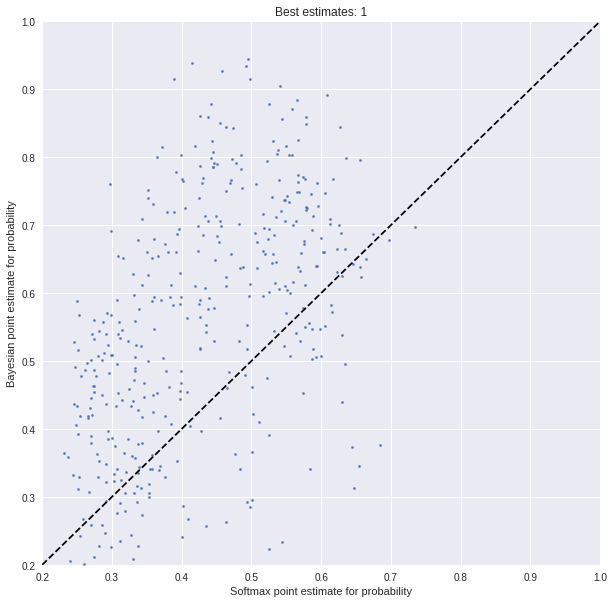

In [41]:
plt.rcParams["figure.figsize"] = (10,10)


ax = plt.scatter(Eprobs_trad1, Eprobs_bayes1, s=5)
plt.xlim(0.2, 1)
plt.ylim(0.2, 1)
plt.xlabel("Softmax point estimate for probability")
plt.ylabel("Bayesian point estimate for probability")
plt.title("Best estimates: 1")
abline(1, 0)

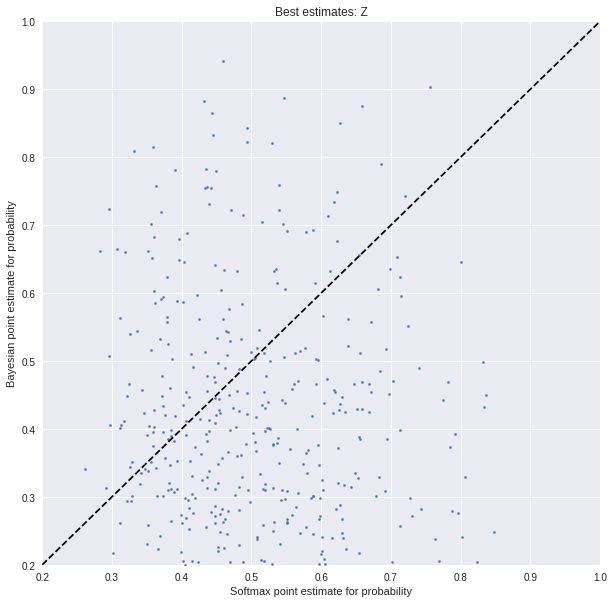

In [42]:
ax = plt.scatter(Eprobs_tradA, Eprobs_bayesA, s=5)
plt.xlim(0.2, 1)
plt.ylim(0.2, 1)
plt.xlabel("Softmax point estimate for probability")
plt.ylabel("Bayesian point estimate for probability")
plt.title("Best estimates: Z")
abline(1, 0)

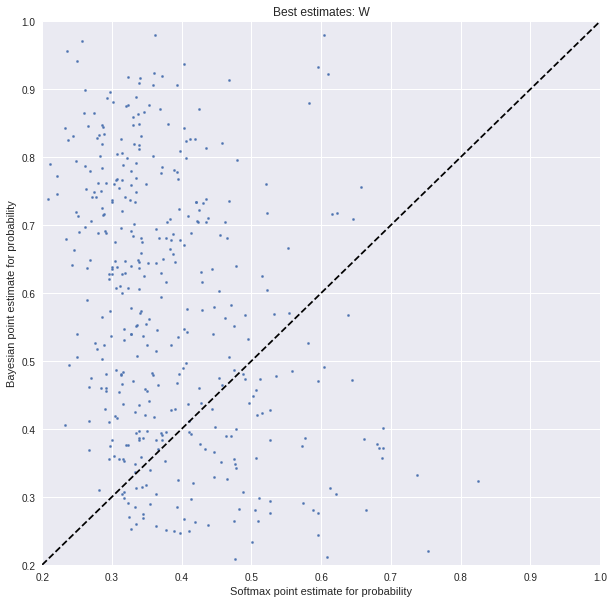

In [43]:
ax = plt.scatter(Eprobs_tradW, Eprobs_bayesW, s=5)
plt.xlim(0.2, 1)
plt.ylim(0.2, 1)
plt.xlabel("Softmax point estimate for probability")
plt.ylabel("Bayesian point estimate for probability")
plt.title("Best estimates: W")
abline(1, 0)

## Active learning

Acquisition function: MI

Start with 20 images. After each training, increase by 10 images based on images with highest MI.N_

### Bayesian

In [58]:
N_train_acq = 2000
N_sample_acq = 100
N_steps = 20

# Store output
Bayes = {}
Trad = {}
Rand = {}


# Initial data set
np.random.seed(123)
start_shuffle = np.random.permutation(mnist.train.images.shape[0])


train_images = mnist.train.images[start_shuffle][0:20]
train_labels = mnist.train.labels[start_shuffle][0:20]

undlab_images = mnist.train.images[start_shuffle][20:10000]
undlab_labels = mnist.train.labels[start_shuffle][20:10000]

for kk in range(N_steps):
  
    # Train model
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())


    for i in range(int(N_train_acq)+1):

        # Training
        _, loss = sess.run([Btrain_step, Bcross_entropy], 
                           feed_dict={x: train_images, y_true: train_labels, 
                                      keep_prob: float(bayesian_keep_prob)})

        # Status report
        if i % 1000 == 0:
            train_acc = sess.run(Baccuracy, feed_dict={x: train_images, 
                                                      y_true: train_labels, 
                                                      keep_prob: float(1.0)})

            test_acc = sess.run(Baccuracy, feed_dict={x: mnist.test.images,
                                                      y_true: mnist.test.labels, 
                                                      keep_prob: 1.0})
            info = [str(tx) for tx in [i, loss, train_acc, test_acc] ]
            print('\t'.join(info))

            

    # Find points model is most uncertain about
    samples = np.zeros( shape=(N_sample_acq, undlab_images.shape[0], 10))

    for n in range(N_sample_acq):
        logits = sess.run(By_conv, feed_dict={x: undlab_images,
                                             keep_prob: bayesian_keep_prob})
        samples[n] = softmax(logits)

    mi = mut_inf(samples)
    

    # Add points to training data
    idx_to_add = np.argsort(mi, axis=0)
    idx_to_add = idx_to_add[-10:]

    train_images = np.append(train_images, undlab_images[idx_to_add], axis=0)
    train_labels = np.append(train_labels, undlab_labels[idx_to_add], axis=0)
    undlab_images = np.delete(undlab_images, idx_to_add, axis=0)
    undlab_labels = np.delete(undlab_labels, idx_to_add, axis=0)


    print("Number of training images: {}: {}".format(kk, train_images.shape))
    print("Number of unlabeled images: {}: {}".format(kk, undlab_images.shape))
    
    Bayes[kk] = "{} {} {}".format(kk, train_images.shape[0], test_acc)


0	9.5304	0.15	0.1275
1000	0.24162062	1.0	0.5505
2000	0.0005320678	1.0	0.5428
Number of training images: 0: (30, 784)
Number of unlabeled images: 0: (9970, 784)
0	6.589206	0.16666667	0.0943
1000	0.30853447	1.0	0.5815
2000	0.24946484	1.0	0.5895
Number of training images: 1: (40, 784)
Number of unlabeled images: 1: (9960, 784)
0	7.3708587	0.2	0.1196
1000	0.2536978	1.0	0.673
2000	0.33349487	1.0	0.6742
Number of training images: 2: (50, 784)
Number of unlabeled images: 2: (9950, 784)
0	8.254278	0.12	0.1306
1000	0.14032376	1.0	0.7324
2000	0.19831255	1.0	0.7349
Number of training images: 3: (60, 784)
Number of unlabeled images: 3: (9940, 784)
0	8.203384	0.05	0.07
1000	0.20855261	1.0	0.7542
2000	0.15889935	1.0	0.7573
Number of training images: 4: (70, 784)
Number of unlabeled images: 4: (9930, 784)
0	6.871859	0.08571429	0.102
1000	0.2235029	1.0	0.8497
2000	0.14856994	1.0	0.8513
Number of training images: 5: (80, 784)
Number of unlabeled images: 5: (9920, 784)
0	6.335212	0.15	0.0834
1000	0.2527

### Freq



In [0]:
def mut_inf_trad(x):
    """ MI between prediction y_pred and posterior distribution for the model parameters. """
    
    print(x.shape)
    N = x.shape[0] # Number of samples per test case
    C = x.shape[1] # number of classes
        
    mis = np.zeros(shape=(N))
    
    # Loop over test examples
    for n in range(N):
        
        # Approx posterior predictive distribution
        ppd = x[n,:]
        
        # Calculate predictive entropy
        pe = - np.sum(np.multiply(ppd, np.log(ppd)))
        
        # Calculate conditional entropy        
        p = x[n,:] + pc
        logp = np.log(p)
        ce = np.mean(np.multiply(p,logp))
        
        mis[n] = pe - ce

    return mis

In [60]:
# Initial data set
np.random.seed(123)
start_shuffle = np.random.permutation(mnist.train.images.shape[0])


train_images = mnist.train.images[start_shuffle][0:20]
train_labels = mnist.train.labels[start_shuffle][0:20]

undlab_images = mnist.train.images[start_shuffle][20:10000]
undlab_labels = mnist.train.labels[start_shuffle][20:10000]


for kk in range(N_steps):
  
    # Train model
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())


    for i in range(int(N_train_acq)+1):

        # Training
        _, loss = sess.run([train_step, cross_entropy], 
                           feed_dict={x: train_images, y_true: train_labels, 
                                      keep_prob: float(bayesian_keep_prob)})

        # Status report
        if i % 1000 == 0:
            train_acc = sess.run(accuracy, feed_dict={x: train_images, 
                                                      y_true: train_labels, 
                                                      keep_prob: float(1.0)})

            test_acc = sess.run(accuracy, feed_dict={x: mnist.test.images,
                                                      y_true: mnist.test.labels, 
                                                      keep_prob: 1.0})
            info = [str(tx) for tx in [i, loss, train_acc, test_acc] ]
            print('\t'.join(info))
            
    
    pred_trad = sess.run(y_prob, feed_dict={x: undlab_images,
                                            keep_prob: 1.0})
    
    mi_trad = mut_inf_trad(pred_trad)
    
    # Add points to training data
    idx_to_add = np.argsort(mi_trad, axis=0)
    idx_to_add = idx_to_add[-10:]

    train_images = np.append(train_images, undlab_images[idx_to_add], axis=0)
    train_labels = np.append(train_labels, undlab_labels[idx_to_add], axis=0)
    undlab_images = np.delete(undlab_images, idx_to_add, axis=0)
    undlab_labels = np.delete(undlab_labels, idx_to_add, axis=0)


    print("Number of training images: {}: {}".format(kk, train_images.shape))
    print("Number of unlabeled images: {}: {}".format(kk, undlab_images.shape))
    
    Trad[kk] = "{} {} {}".format(kk, train_images.shape[0], test_acc)

0	5.5173545	0.1	0.089
1000	0.26599467	1.0	0.55
2000	0.28941697	1.0	0.5504
(9980, 10)
Number of training images: 0: (30, 784)
Number of unlabeled images: 0: (9970, 784)
0	6.0718937	0.16666667	0.0989
1000	0.2132504	1.0	0.615
2000	0.34910944	1.0	0.6199
(9970, 10)
Number of training images: 1: (40, 784)
Number of unlabeled images: 1: (9960, 784)
0	5.0283813	0.15	0.1054
1000	0.22630616	1.0	0.6624
2000	0.13521138	1.0	0.6668
(9960, 10)
Number of training images: 2: (50, 784)
Number of unlabeled images: 2: (9950, 784)
0	5.2114983	0.04	0.0472
1000	0.27159172	1.0	0.6814
2000	0.2243267	1.0	0.6958
(9950, 10)
Number of training images: 3: (60, 784)
Number of unlabeled images: 3: (9940, 784)
0	6.1600046	0.06666667	0.1168
1000	0.24799916	1.0	0.698
2000	0.18452232	1.0	0.7212
(9940, 10)
Number of training images: 4: (70, 784)
Number of unlabeled images: 4: (9930, 784)
0	4.098202	0.114285715	0.1869
1000	0.17956543	1.0	0.7621
2000	0.2574121	1.0	0.7775
(9930, 10)
Number of training images: 5: (80, 784)
Nu

### Random choice of pictures

In [61]:
# Initial data set
np.random.seed(123)
start_shuffle = np.random.permutation(mnist.train.images.shape[0])


train_images = mnist.train.images[start_shuffle][0:20]
train_labels = mnist.train.labels[start_shuffle][0:20]

undlab_images = mnist.train.images[start_shuffle][20:10000]
undlab_labels = mnist.train.labels[start_shuffle][20:10000]


for kk in range(N_steps):
  
    # Train model
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())


    for i in range(int(N_train_acq)+1):

        # Training
        _, loss = sess.run([train_step, cross_entropy], 
                           feed_dict={x: train_images, y_true: train_labels, 
                                      keep_prob: float(bayesian_keep_prob)})

        # Status report
        if i % 1000 == 0:
            train_acc = sess.run(accuracy, feed_dict={x: train_images, 
                                                      y_true: train_labels, 
                                                      keep_prob: float(1.0)})

            test_acc = sess.run(accuracy, feed_dict={x: mnist.test.images,
                                                      y_true: mnist.test.labels, 
                                                      keep_prob: 1.0})
            info = [str(tx) for tx in [i, loss, train_acc, test_acc] ]
            print('\t'.join(info))
            
    
    pred_trad = sess.run(y_prob, feed_dict={x: undlab_images,
                                            keep_prob: 1.0})
    
    mi_trad = mut_inf_trad(pred_trad)
    
    # Add points to training data
    np.random.seed(123)
    run_shuffle = np.random.permutation(undlab_images.shape[0])

    
    idx_to_add = run_shuffle[0:10]

    train_images = np.append(train_images, undlab_images[idx_to_add], axis=0)
    train_labels = np.append(train_labels, undlab_labels[idx_to_add], axis=0)
    undlab_images = np.delete(undlab_images, idx_to_add, axis=0)
    undlab_labels = np.delete(undlab_labels, idx_to_add, axis=0)


    print("Number of training images: {}: {}".format(kk, train_images.shape))
    print("Number of unlabeled images: {}: {}".format(kk, undlab_images.shape))
    
    Rand[kk] = "{} {} {}".format(kk, train_images.shape[0], test_acc)

0	4.3237143	0.3	0.1503
1000	0.11151743	1.0	0.5559
2000	7.895027e-05	1.0	0.5612
(9980, 10)
Number of training images: 0: (30, 784)
Number of unlabeled images: 0: (9970, 784)
0	5.3015947	0.033333335	0.0532
1000	0.1704352	1.0	0.6268
2000	0.27619556	1.0	0.6285
(9970, 10)
Number of training images: 1: (40, 784)
Number of unlabeled images: 1: (9960, 784)
0	5.1102	0.125	0.0994
1000	0.1941204	1.0	0.6915
2000	0.28647065	1.0	0.6864
(9960, 10)
Number of training images: 2: (50, 784)
Number of unlabeled images: 2: (9950, 784)
0	5.2343354	0.16	0.0998
1000	0.19353463	1.0	0.7042
2000	0.3724304	1.0	0.71
(9950, 10)
Number of training images: 3: (60, 784)
Number of unlabeled images: 3: (9940, 784)
0	8.188283	0.05	0.0853
1000	0.26131973	1.0	0.7218
2000	0.24784404	1.0	0.7267
(9940, 10)
Number of training images: 4: (70, 784)
Number of unlabeled images: 4: (9930, 784)
0	5.563351	0.15714286	0.0789
1000	0.15301283	1.0	0.7399
2000	0.19272202	1.0	0.7505
(9930, 10)
Number of training images: 5: (80, 784)
Number

In [64]:
run_shuffle[0:10]

array([1131, 1743, 4042,  449, 3223, 2738, 8690, 7484, 2282, 8970])

### Results

In [65]:
df = pd.DataFrame(columns = ['idx', 'nbr_images', 'acc_trad', 'acc_bayes'])

for k in range(len(Bayes.keys())):
  spB = Bayes[k].split(' ')
  spT = Trad[k].split(' ')
  spR = Rand[k].split(' ')
  
  df = df.append( pd.DataFrame({'idx': float(spB[0]),
                           'nbr_images': float(spB[1]),
                           'acc_trad': float(spT[2]),
                           'acc_bayes': float(spB[2]),
                           'acc_rand': float(spR[2])}, index = [k]))
df

,acc_bayes,acc_rand,acc_trad,idx,nbr_images
0,0.5428,0.5612,0.5504,0.0,30.0
1,0.5895,0.6285,0.6199,1.0,40.0
2,0.6742,0.6864,0.6668,2.0,50.0
3,0.7349,0.7100,0.6958,3.0,60.0
4,0.7573,0.7267,0.7212,4.0,70.0
5,0.8513,0.7505,0.7775,5.0,80.0
6,0.8520,0.7685,0.8038,6.0,90.0
7,0.8805,0.7891,0.8210,7.0,100.0
8,0.8641,0.8115,0.8538,8.0,110.0
9,0.8797,0.8351,0.8408,9.0,120.0


(25, 125)

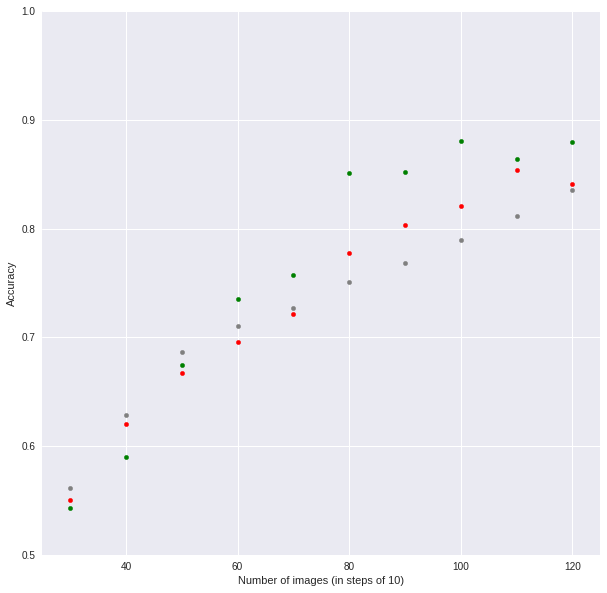

In [74]:
ax = df.plot.scatter(x = 'nbr_images',
                     y = 'acc_bayes',
                     color = 'green')
df.plot.scatter(x = 'nbr_images',
                y = 'acc_trad',
                ax = ax,
                color = 'red')
df.plot.scatter(x = 'nbr_images',
                y = 'acc_rand',
                ax = ax,
                color = 'gray')

ax.set_xlabel('Number of images (in steps of 10)')
ax.set_ylabel('Accuracy')
ax.set_ylim(0.5,1.0)
ax.set_xlim(25,125)

In [49]:
Trad

{0: '0 30 0.10700000077486038', 1: '1 40 0.0723000019788742'}

In [50]:
total_parameters = 0
for variable in tf.trainable_variables():
    # shape is an array of tf.Dimension
    shape = variable.get_shape()
    print(shape)
    print(len(shape))
    variable_parameters = 1
    for dim in shape:
        print(dim)
        variable_parameters *= dim.value
    print(variable_parameters)
    total_parameters += variable_parameters
print(total_parameters)

(3, 3, 1, 32)
4
3
3
1
32
288
(32,)
1
32
32
(3, 3, 32, 64)
4
3
3
32
64
18432
(64,)
1
64
64
(3136, 1024)
2
3136
1024
3211264
(1024,)
1
1024
1024
(1024, 10)
2
1024
10
10240
(10,)
1
10
10
(3, 3, 1, 32)
4
3
3
1
32
288
(32,)
1
32
32
(3, 3, 32, 64)
4
3
3
32
64
18432
(64,)
1
64
64
(3136, 1024)
2
3136
1024
3211264
(1024,)
1
1024
1024
(1024, 10)
2
1024
10
10240
(10,)
1
10
10
6482708
